In [1]:
#import libraries....

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import Normalizer,MinMaxScaler,StandardScaler

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder



import datetime

import warnings
warnings.filterwarnings("ignore")

### Choosing metric
* From EDA part, It is sure that there is high class imbalance in the dataset. Also review_score 1,2,3 are very important, since misclassification of them would cause customer loss to the seller. So False positive should be the concern here. 
* Here precision and recall of each class is important. Precision of class 4,5 is more important and recall of 1,2,3 class is very important. So we can use f1 score,which is a combination of precision and recall, Since each is important to us we can consider Macro f1 score.. 
* Based on this observation and business problem, I choose Macro F1 score as metric. Also I want to check multi-class confusion matrix, so that we can observe the misclassification easily.

<b>Metric choosen,
    * Macro F1 score
    * Multi-class Confusion matrix

### Multi class classification among 1,2,3,4

In [2]:
#load the data with all created features
data = pd.read_csv("data_with_advanced_features.csv")
data.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113105 entries, 0 to 113104
Data columns (total 71 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113105 non-null  object 
 1   payment_sequential             113105 non-null  int64  
 2   payment_type                   113105 non-null  object 
 3   payment_installments           113105 non-null  int64  
 4   payment_value                  113105 non-null  float64
 5   customer_id                    113105 non-null  object 
 6   order_status                   113105 non-null  object 
 7   order_purchase_timestamp       113105 non-null  object 
 8   order_approved_at              113105 non-null  object 
 9   order_delivered_carrier_date   113105 non-null  object 
 10  order_delivered_customer_date  113105 non-null  object 
 11  order_estimated_delivery_date  113105 non-null  object 
 12  review_score                  

In [4]:
#label encoding of seller_id
label = LabelEncoder()
seller = label.fit_transform(data.seller_id)
data["seller_id"] = seller


#label encoding of product id
label = LabelEncoder()
product = label.fit_transform(data.product_id)
data["product_id"] = product


In [5]:
#let us drop some of the columns which are not needed
data.drop(["order_id","customer_id","order_status","order_approved_at","order_delivered_carrier_date",
           "order_estimated_delivery_date","order_delivered_customer_date","customer_unique_id","customer_city",
          "seller_city","shipping_limit_date","seller_state","customer_state",
           "order_purchase_timestamp"],inplace=True,axis=1)

In [6]:
#shape of the data after dropping unnecessary columns
data.shape

(113105, 57)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113105 entries, 0 to 113104
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   payment_sequential           113105 non-null  int64  
 1   payment_type                 113105 non-null  object 
 2   payment_installments         113105 non-null  int64  
 3   payment_value                113105 non-null  float64
 4   review_score                 113105 non-null  int64  
 5   zip_code_prefix_customer     113105 non-null  int64  
 6   lat_customer                 113105 non-null  float64
 7   lng_customer                 113105 non-null  float64
 8   product_id                   113105 non-null  int32  
 9   product_name_lenght          113105 non-null  float64
 10  product_description_lenght   113105 non-null  float64
 11  product_photos_qty           113105 non-null  float64
 12  product_weight_g             113105 non-null  float64
 13 

## 1.1 Stratified Splitting

In [8]:
data = data[data["review_score"]!=5]
Y = data["review_score"]
X = data

In [9]:
#train test split with test size 25% and 75% of data as train
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,stratify=Y,random_state=10)

In [10]:
print("Dimensions of the splitted data :")
print("Train: ",x_train.shape,y_train.shape)
print("Test: ",x_test.shape,y_test.shape)

Dimensions of the splitted data :
Train:  (36351, 57) (36351,)
Test:  (12117, 57) (12117,)


In [11]:
#check the distribution of each class in train,test as well as original data
print("% Distribution of class labels in the total data :")
print(round(data["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the train data :")
print(round(x_train["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the test data :")
print(round(x_test["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)


% Distribution of class labels in the total data :
4    44.82
1    27.32
3    19.75
2     8.11
Name: review_score, dtype: float64
**************************************************
% Distribution of class labels in the train data :
4    44.82
1    27.32
3    19.75
2     8.10
Name: review_score, dtype: float64
**************************************************
% Distribution of class labels in the test data :
4    44.82
1    27.32
3    19.75
2     8.11
Name: review_score, dtype: float64
**************************************************


* Distribution of each class label is same in train.test and original data.


<b> let us use simple CountVectorizer for categorical data.

## 1.2 Featurization:

### 1.2.1 Vectorization of categorical variables:

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

<b>1. payment_type

In [13]:
#payment_type 
vec = CountVectorizer()

vec.fit(x_train["payment_type"].values)

x_tr_pay_type = vec.transform(x_train.payment_type.values)
x_te_pay_type = vec.transform(x_test.payment_type.values)

print(x_tr_pay_type.shape)
print(x_te_pay_type.shape)


(36351, 4)
(12117, 4)


<b>2. order_item_id

In [14]:
x_train.order_item_id = x_train.order_item_id.astype(str)
x_test.order_item_id = x_test.order_item_id.astype(str)

In [15]:
#order_item_id 
vec = CountVectorizer(vocabulary=range(1,22))

vec.fit(x_train["order_item_id"])

x_tr_id = vec.transform(x_train.order_item_id)
x_te_id = vec.transform(x_test.order_item_id)

print(x_tr_id.shape)

print(x_te_id.shape)


(36351, 21)
(12117, 21)


<b>3. product_category_name

In [16]:
#product_category_name
vec = CountVectorizer()

vec.fit(x_train["product_category_name"].values)

x_tr_cat = vec.transform(x_train.product_category_name.values)
#x_cv_cat = vec.transform(x_cv.product_category_name.values).toarray()
x_te_cat = vec.transform(x_test.product_category_name.values)

print(x_tr_cat.shape)
#print(x_cv_cat.shape)
print(x_te_cat.shape)


(36351, 72)
(12117, 72)


### 1.2.2 Binary features

In [17]:
x_tr_same_state = x_train.same_state.values.reshape(-1,1)
x_te_same_state = x_test.same_state.values.reshape(-1,1)

x_tr_same_city = x_train.same_city.values.reshape(-1,1)
x_te_same_city = x_test.same_city.values.reshape(-1,1)

x_tr_late_shipping = x_train.late_shipping.values.reshape(-1,1)
x_te_late_shipping = x_test.late_shipping.values.reshape(-1,1)

x_tr_high_freight = x_train.high_freight.values.reshape(-1,1)
x_te_high_freight = x_test.high_freight.values.reshape(-1,1)

### 1.2.3 Numrical features

In [18]:

def scaling(train_data,test_data):
    """This function will standardize the numerical data"""
    norm = StandardScaler()

    norm.fit(train_data.values)

    x_tr_num = norm.transform(train_data.values)
    x_te_num = norm.transform(test_data.values)


    return x_tr_num,x_te_num

In [19]:
data.columns

Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'zip_code_prefix_customer',
       'lat_customer', 'lng_customer', 'product_id', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_item_id', 'seller_id', 'price', 'freight_value',
       'zip_code_prefix_seller', 'lat_seller', 'lng_seller',
       'product_category_name', 'estimated_time', 'actual_time',
       'diff_actual_estimated', 'diff_purchased_approved',
       'diff_purchased_courrier', 'distance', 'speed', 'same_state',
       'same_city', 'late_shipping', 'high_freight', 'seller_share',
       'bs_share', 'cust_share', 'bu_share', 'similarity',
       'seller_category_share', 'cat_seller_share', 'cust_category_share',
       'cat_cust_share', 'similarity_using_cat', 'size', 'delivery_day',
       'delivery_date', 'delivery_month', 'del

In [20]:
#data to be standardized
tr = x_train[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]

te = x_test[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]


In [21]:
#standardizing
x_tr_num,x_te_num = scaling(tr,te)

In [22]:
from scipy.sparse import hstack
#horizontal stacking of all the features
train = hstack((x_tr_pay_type,x_tr_id,x_tr_cat,x_tr_num,x_tr_same_state,
                   x_tr_same_city,x_tr_late_shipping,x_tr_high_freight)).toarray()

test = hstack((x_te_pay_type,x_te_id,x_te_cat,x_te_num,x_te_same_state,
                 x_te_same_city,x_te_late_shipping,x_te_high_freight)).toarray()

In [23]:
#shape of final train and test data
print("Shape of train data : ",train.shape)
print("Shape of test data : ",test.shape)

Shape of train data :  (36351, 141)
Shape of test data :  (12117, 141)


In [24]:
#reset the index of target variable
y_trains = y_train.reset_index()
y_train = y_trains["review_score"]

y_tests = y_test.reset_index()
y_test = y_tests["review_score"]

## 1.3 ML Models

<b> Plotting Confusion matrix

In [25]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    """This function will plot confusion matrix, precision matrix and recall matrix"""
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<b>k-fold cross validation

In [26]:
def kfold(k,model,trains,y_trains):
    """This function will do stratified k-fold cross_validation"""
    kf = StratifiedKFold(n_splits=k)
    
    cv_f1_score = []
    for tr_ind,cv_ind in kf.split(trains,y_trains):
            
        x_tr,x_cv,y_tr,y_cv = trains[tr_ind],trains[cv_ind],y_trains[tr_ind],y_trains[cv_ind]
        
        model.fit(x_tr,y_tr)
        pred_cv = model.predict(x_cv)    
        cv_f1_score.append((f1_score(y_cv,pred_cv,average="macro",labels=[1,2,3,4])))
    
    return np.mean(cv_f1_score)               

### 1.3.1 Logistic regression
<b> One vs Rest with class_weight = balanced

Macro F1 score at C=1e-05 is 0.3408694726197833 
Macro F1 score at C=0.0001 is 0.3508066060297175 
Macro F1 score at C=0.001 is 0.3562882159133647 
Macro F1 score at C=0.01 is 0.35816843119316666 
Macro F1 score at C=0.1 is 0.3572851056412578 
Macro F1 score at C=1 is 0.3561208072083494 
Macro F1 score at C=10 is 0.3568396308276774 
**************************************************


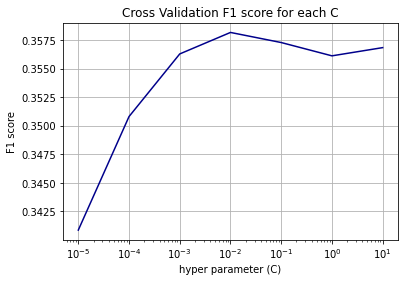

**************************************************
Train F1 score at 0.01 is :0.3681109726049413
**************************************************
test F1 score at 0.01 is :0.358549166584471
-------------------- Confusion matrix --------------------


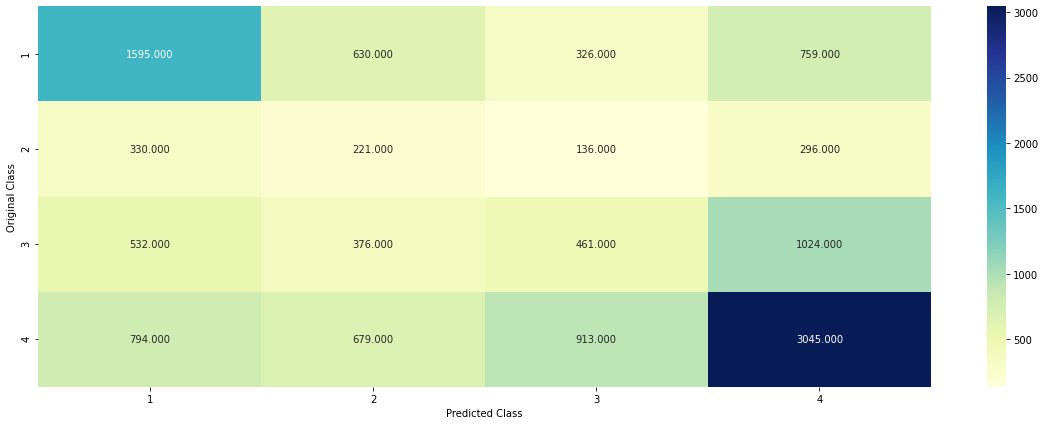

-------------------- Precision matrix (Columm Sum=1) --------------------


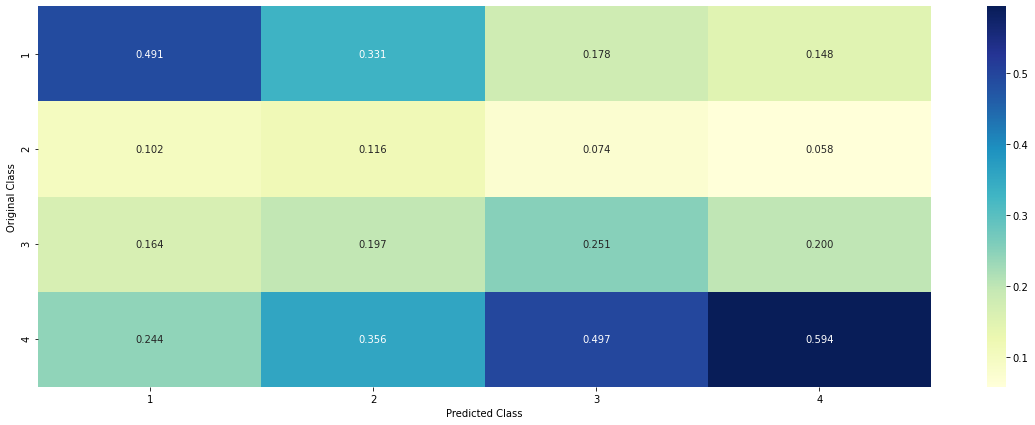

-------------------- Recall matrix (Row sum=1) --------------------


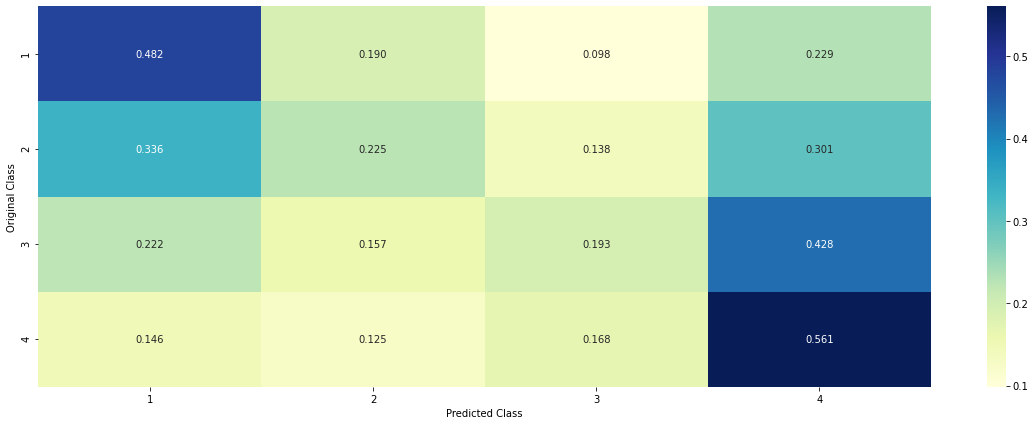

In [27]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i,class_weight="balanced")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### 1.3.3 KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier


Macro F1 score at n=3 is 0.39032718850195314 
Macro F1 score at n=5 is 0.3862115895646426 
Macro F1 score at n=7 is 0.3719419243213421 
Macro F1 score at n=9 is 0.360790847235193 
Macro F1 score at n=11 is 0.35448864080785264 
Macro F1 score at n=13 is 0.34392322863482117 
**************************************************


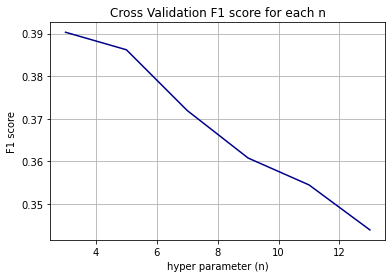

**************************************************
Train F1 score at 3 is :0.6909387502185933
**************************************************
test F1 score at 3 is :0.4086244552678359
-------------------- Confusion matrix --------------------


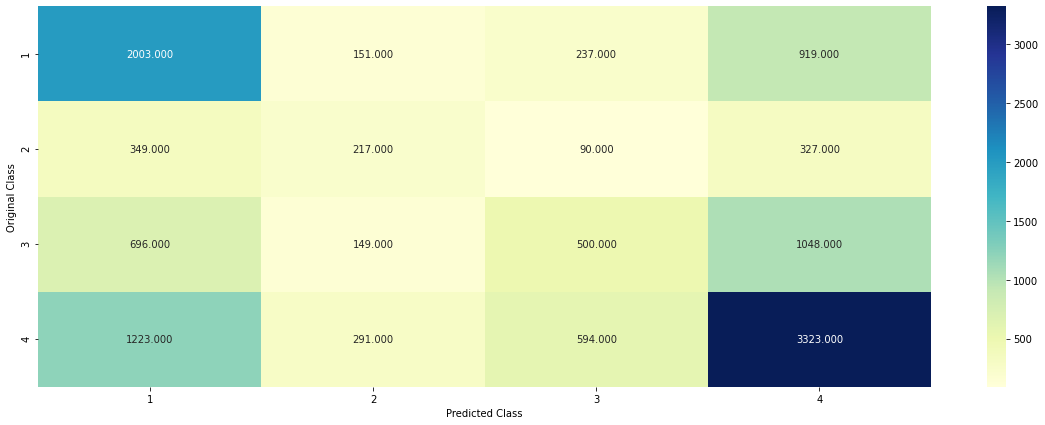

-------------------- Precision matrix (Columm Sum=1) --------------------


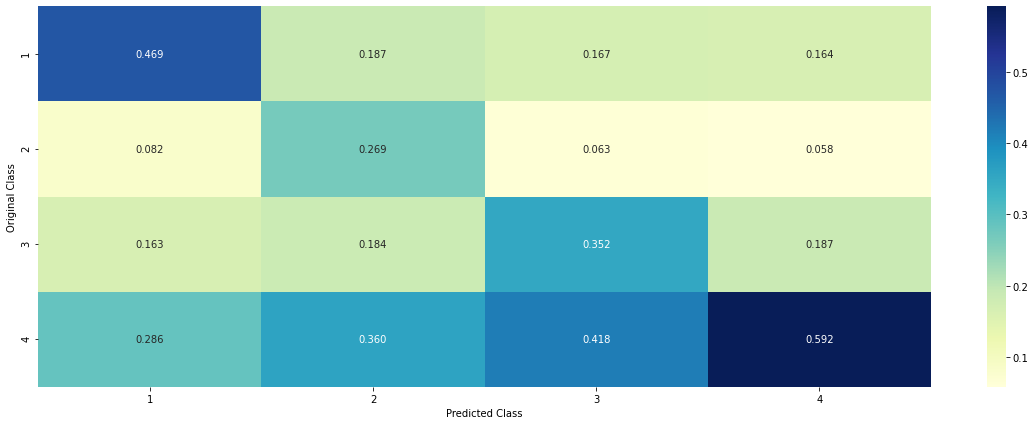

-------------------- Recall matrix (Row sum=1) --------------------


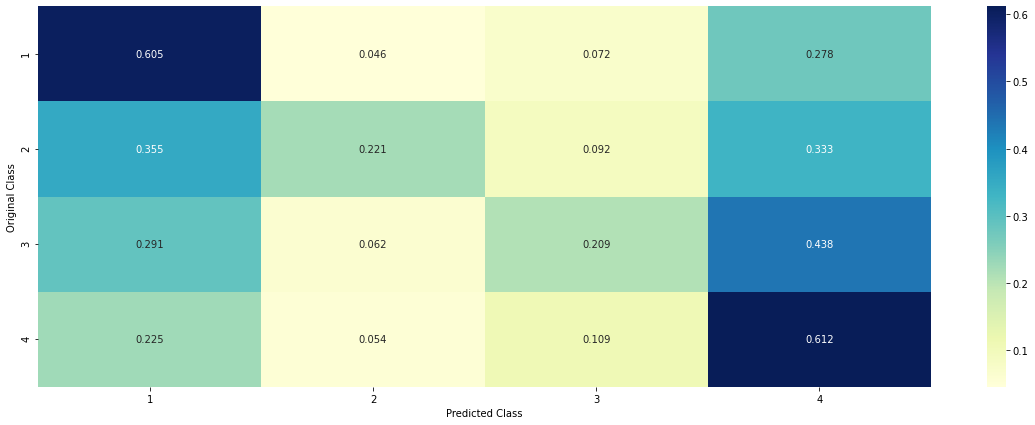

In [29]:
n=[3,5,7,9,11,13]

f1_scores = []
for i in n:
    model = None
    model = KNeighborsClassifier(n_neighbors=i)
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n")
plt.xlabel("hyper parameter (n)")
plt.ylabel("F1 score")
plt.show()

best_param = n[np.argmax(f1_scores)]

model = None
model = KNeighborsClassifier(n_neighbors=best_param)
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### 1.3.4. Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

Macro F1 score at n=2 is 0.305879001111935 
Macro F1 score at n=5 is 0.36170352428663005 
Macro F1 score at n=6 is 0.36068181314349834 
Macro F1 score at n=8 is 0.36896634903191633 
Macro F1 score at n=10 is 0.3785064920310101 
Macro F1 score at n=12 is 0.38937902359723175 
Macro F1 score at n=15 is 0.40119881592265144 
**************************************************


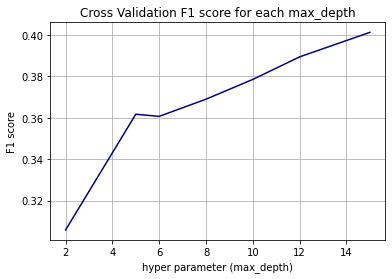

**************************************************
Train F1 score at 15 is :0.5752756308273197
**************************************************
test F1 score at 15 is :0.4157922606719481
-------------------- Confusion matrix --------------------


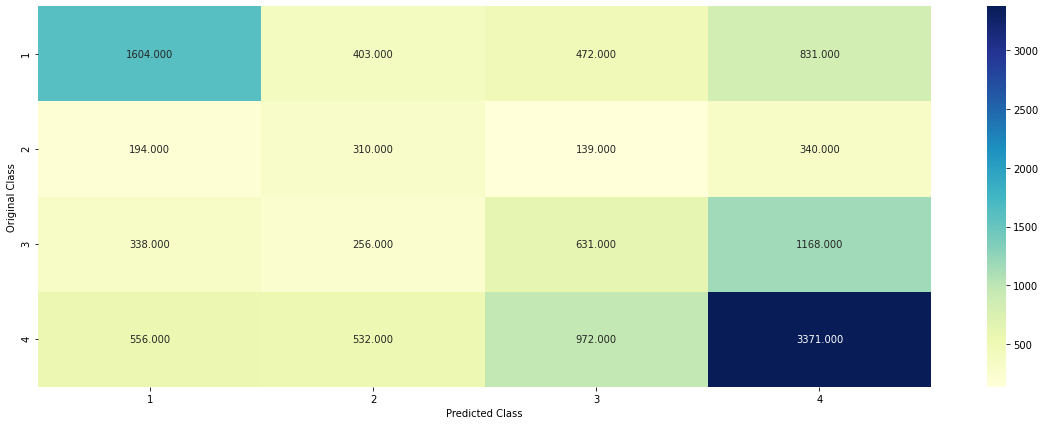

-------------------- Precision matrix (Columm Sum=1) --------------------


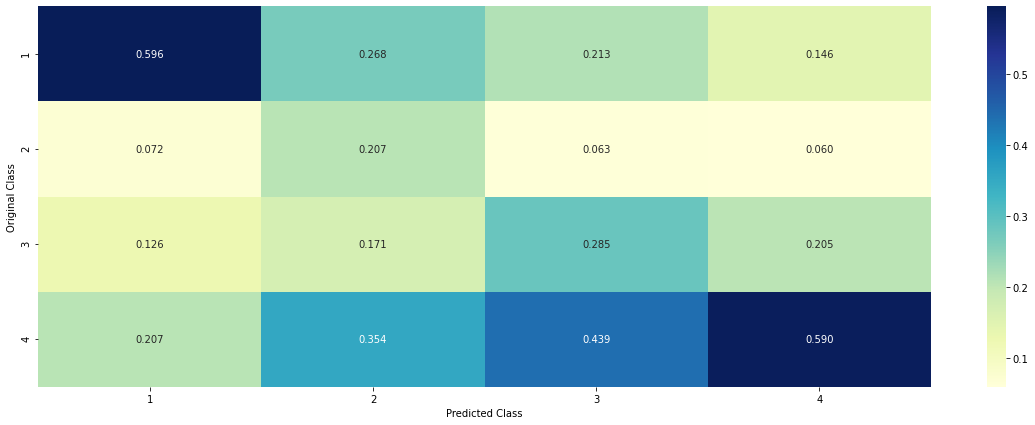

-------------------- Recall matrix (Row sum=1) --------------------


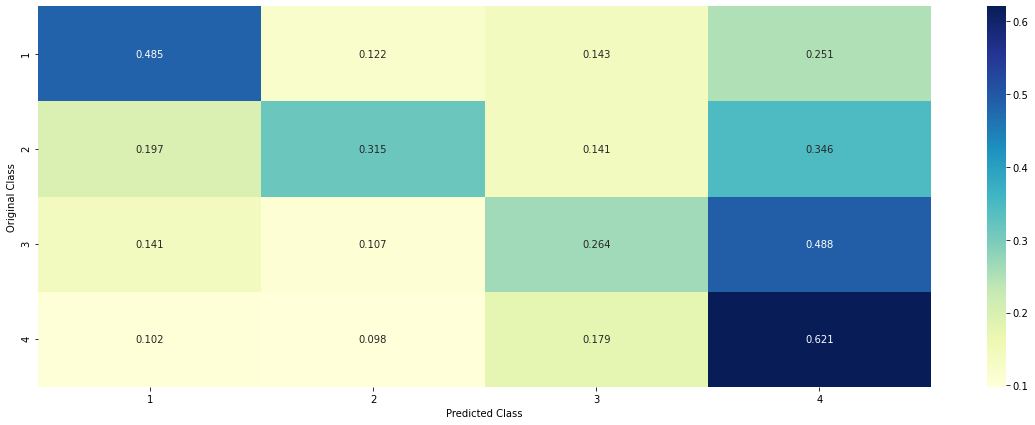

In [31]:
max_depth=[2,5,6,8,10,12,15]

f1_scores = []
for i in max_depth:
    model = None
    model = DecisionTreeClassifier(max_depth=i,class_weight="balanced")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(max_depth,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each max_depth")
plt.xlabel("hyper parameter (max_depth)")
plt.ylabel("F1 score")
plt.show()

best_param = max_depth[np.argmax(f1_scores)]

model = None
model = DecisionTreeClassifier(max_depth=best_param,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### 1.3.5. Random Forest classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

Macro F1 score at n=10 is 0.46226412790634697 
Macro F1 score at n=20 is 0.4940921825780281 
Macro F1 score at n=50 is 0.5021446392695073 
Macro F1 score at n=100 is 0.5119435620917232 
Macro F1 score at n=150 is 0.5125885537504458 
Macro F1 score at n=200 is 0.5133419960153349 
Macro F1 score at n=300 is 0.5128666790986646 
Macro F1 score at n=500 is 0.5147210814540222 
**************************************************


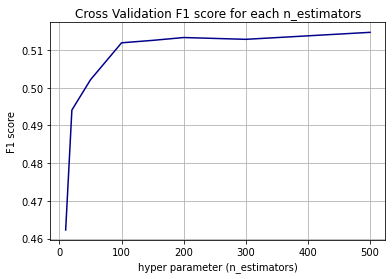

**************************************************
Train F1 score at 500 is :0.9975734278864823
**************************************************
test F1 score at 500 is :0.5526927705765561
-------------------- Confusion matrix --------------------


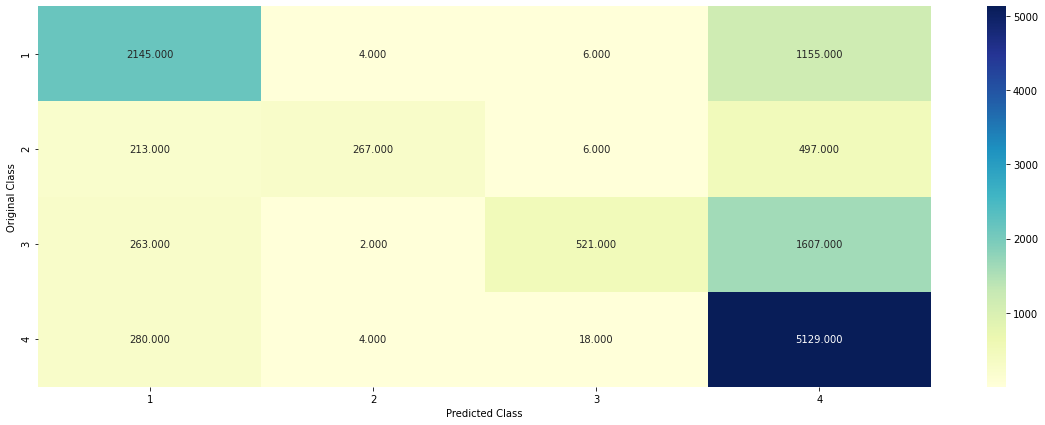

-------------------- Precision matrix (Columm Sum=1) --------------------


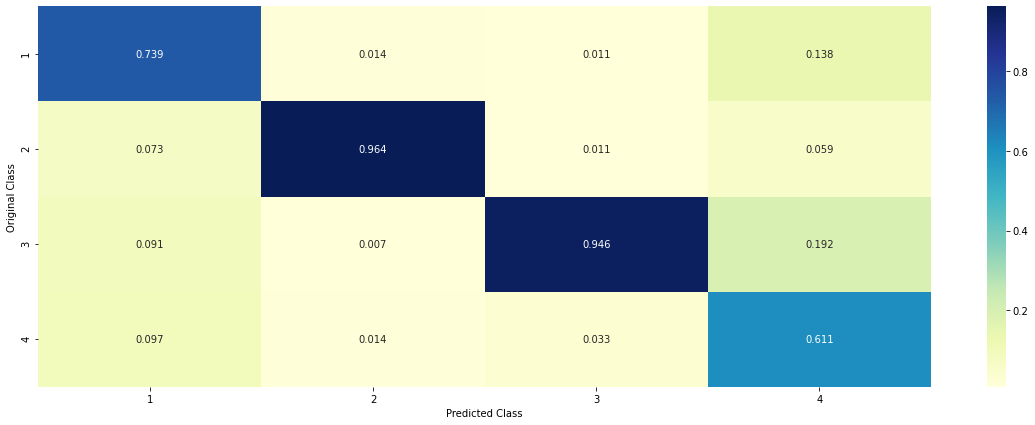

-------------------- Recall matrix (Row sum=1) --------------------


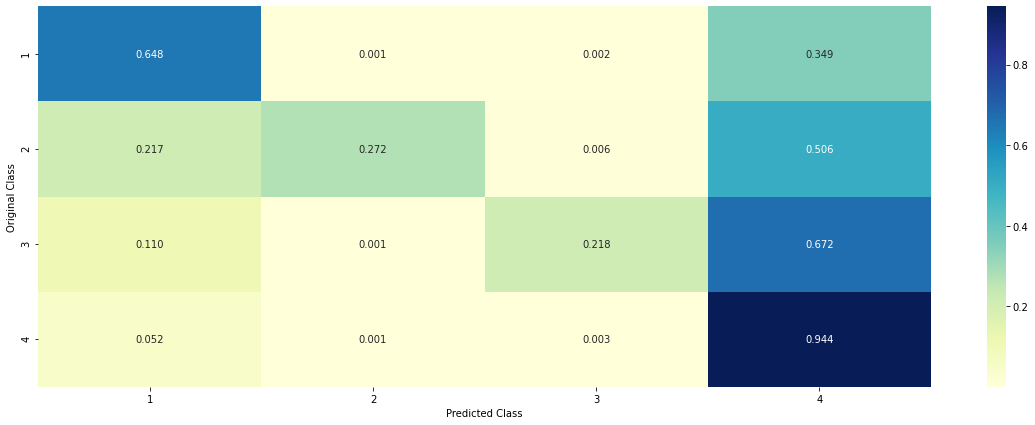

In [33]:
n_estimators=[10,20,50,100,150,200,300,500]


f1_scores = []
for i in n_estimators:
    model = None
    model = RandomForestClassifier(n_estimators=i,class_weight="balanced")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_param = n_estimators[np.argmax(f1_scores)]

model = None
model = RandomForestClassifier(n_estimators=best_param,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### 1.3.6. LightGBM

In [36]:
import lightgbm as lgb

Macro F1 score at n=100 is 0.4380547859100788 
Macro F1 score at n=150 is 0.4483338364155416 
Macro F1 score at n=200 is 0.45573070077347655 
Macro F1 score at n=300 is 0.46934927527792114 
Macro F1 score at n=500 is 0.4882244550974746 
Macro F1 score at n=1000 is 0.5063847020110472 
Macro F1 score at n=2000 is 0.517508382787191 
**************************************************


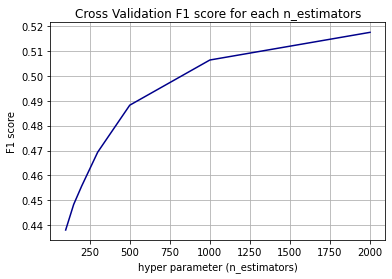

**************************************************
Train F1 score at 2000 is  :0.9975734530666492 
**************************************************
test F1 score at 2000 is :0.544724564220289 
-------------------- Confusion matrix --------------------


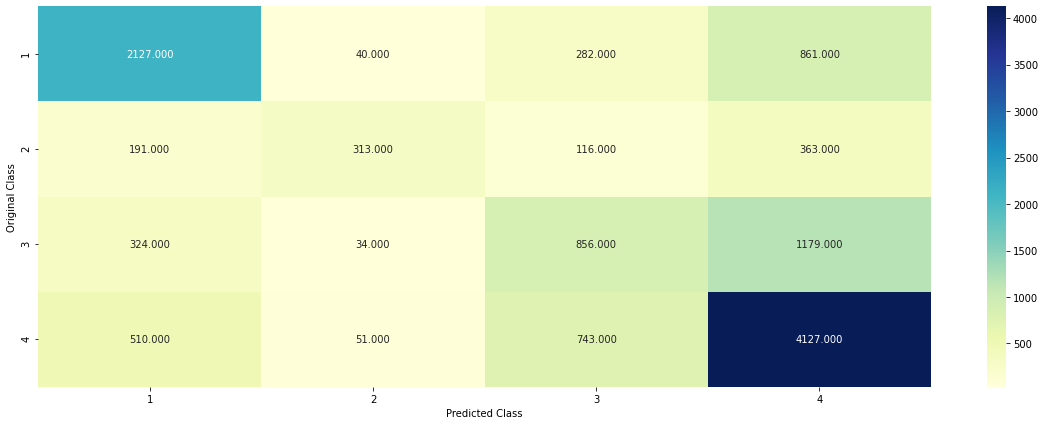

-------------------- Precision matrix (Columm Sum=1) --------------------


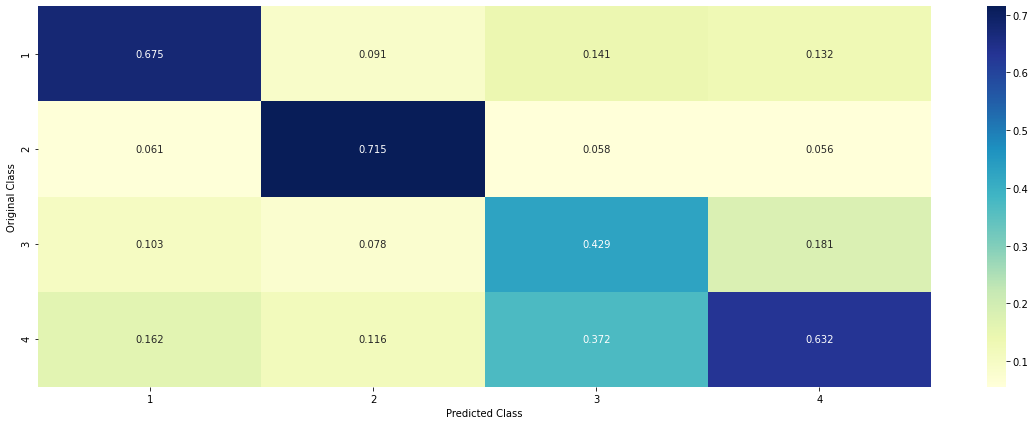

-------------------- Recall matrix (Row sum=1) --------------------


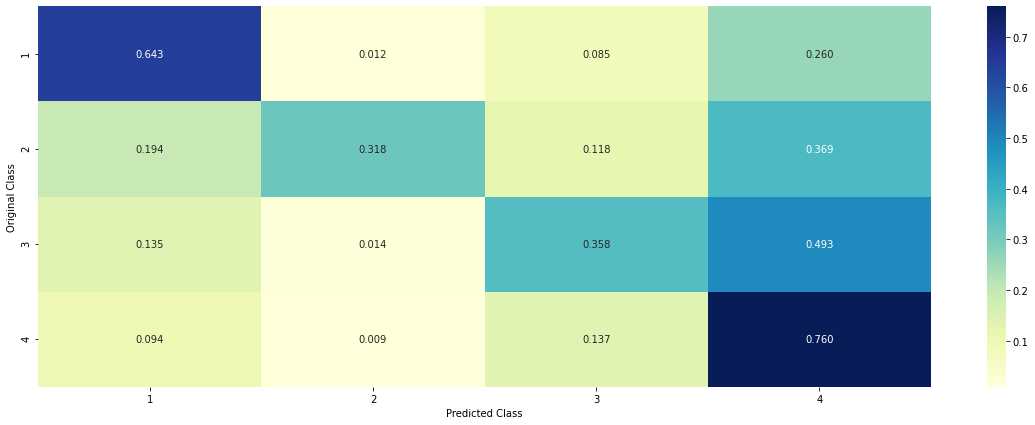

In [37]:
n_estimators=[100,150,200,300,500,1000,2000]

f1_scores = []
for i in n_estimators:
    model = None
    model = lgb.LGBMClassifier(n_estimators=i,class_weight="balanced",boosting_type ="goss")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_n = n_estimators[np.argmax(f1_scores)]


model = None
model = lgb.LGBMClassifier(n_estimators=best_n,class_weight='balanced',boosting_type="goss")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)


In [38]:

print(model.feature_importances_)

[  279   289   109   156     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     8    24    10     0    40   177   185   256     9     0    20
     0     5     0     9   230    91    99    43    22   141    10     3
     0    32     0   114     0   103    22     9     0     5    39     0
    22    23     0   250    39     0   125   270    47    14     0    37
    72   255    15    22     0     0    79    17     0    83    62     0
     0   150   150     0    16    53     0   286    89     8   158   173
   123   142  2793  8023  7508  9462  5320   605  5044   569  8849  9224
  6718  6735  5938  8703  1899  6612  7475  7541  2621  6302  2943  5014
  2835  6096  2918  5428  4710  1013     0  8221  8808  8382  9012 10395
 10038  7106  8487  5901  8718   132   120   297   166]


In [39]:
##############################################################################################################################

### Feature selection

In [40]:
#https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

from sklearn.feature_selection import SelectKBest,f_classif

features = SelectKBest(f_classif,k=60)
train_features = features.fit_transform(train,y_train)
test_features = features.transform(test)

### LGBM

Macro F1 score at n=100 is 0.4350576594814185 
Macro F1 score at n=150 is 0.4466000278945315 
Macro F1 score at n=200 is 0.4564406051093023 
Macro F1 score at n=300 is 0.46793762513066595 
Macro F1 score at n=500 is 0.4836929832980411 
Macro F1 score at n=1000 is 0.49953966899336455 
Macro F1 score at n=2000 is 0.5126493516544504 
**************************************************


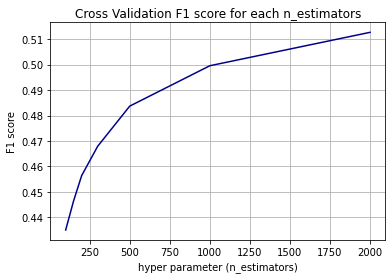

**************************************************
Train F1 score at 2000 is  :0.9975734530666492 
**************************************************
test F1 score at 2000 is :0.5369701393349094 
-------------------- Confusion matrix --------------------


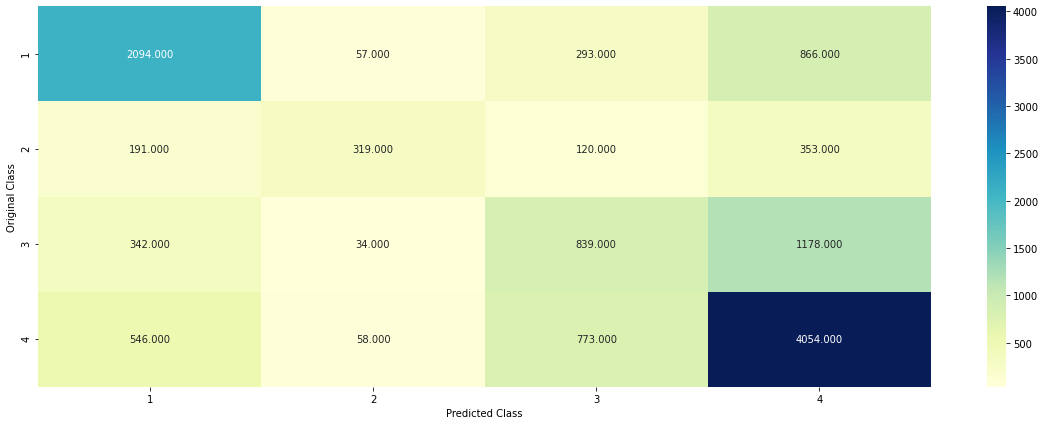

-------------------- Precision matrix (Columm Sum=1) --------------------


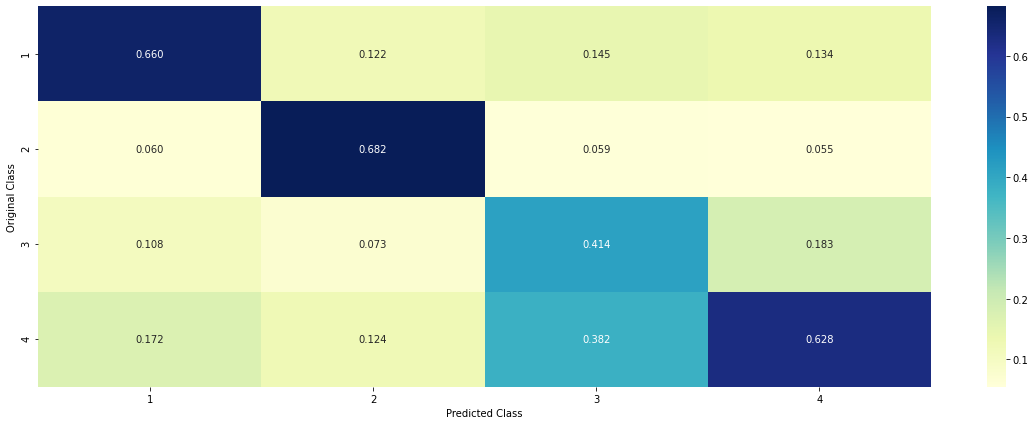

-------------------- Recall matrix (Row sum=1) --------------------


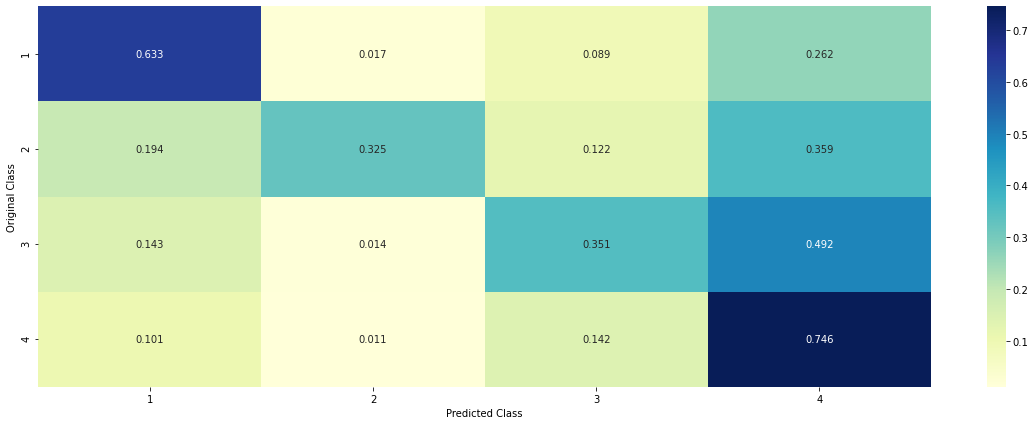

In [41]:
n_estimators=[100,150,200,300,500,1000,2000]

f1_scores = []
for i in n_estimators:
    model = None
    model = lgb.LGBMClassifier(n_estimators=i,class_weight="balanced",boosting_type ="goss")
    k_fold_score = kfold(5,model,train_features,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_n = n_estimators[np.argmax(f1_scores)]


model = None
model = lgb.LGBMClassifier(n_estimators=best_n,class_weight='balanced',boosting_type="goss")
model.fit(train_features,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train_features),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

In [42]:
importance = model.feature_importances_

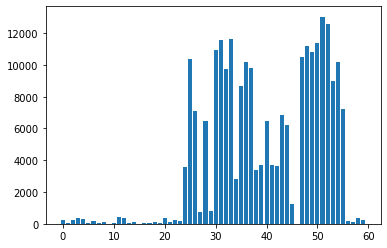

In [43]:
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### 1.3.7. XGBoost (Original features)

[10:59:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:59:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:59:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not 

[11:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not 

[11:05:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

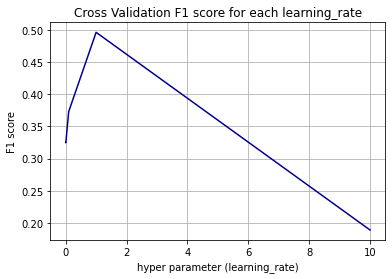

[11:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************
Train F1 score at 1 is  :0.9484680258119806 
**************************************************
test F1 score at 1 is :0.5149071045702365 
-------------------- Confusion matrix --------------------


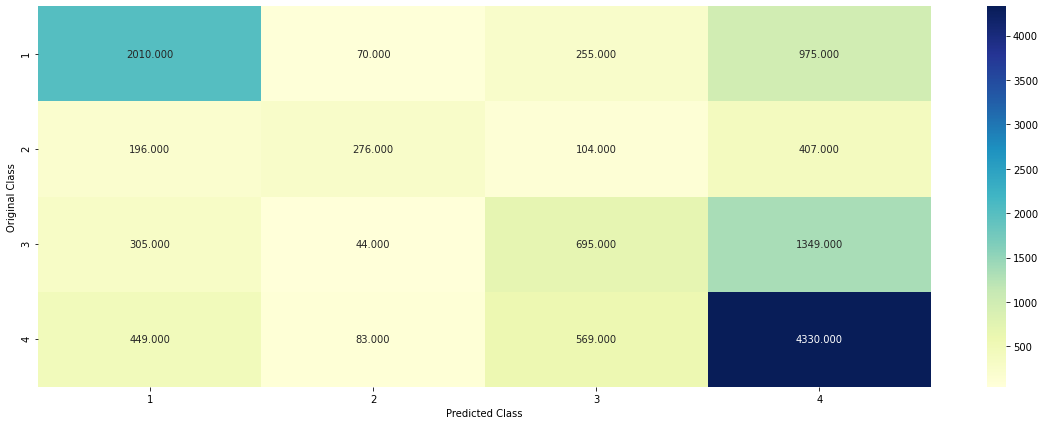

-------------------- Precision matrix (Columm Sum=1) --------------------


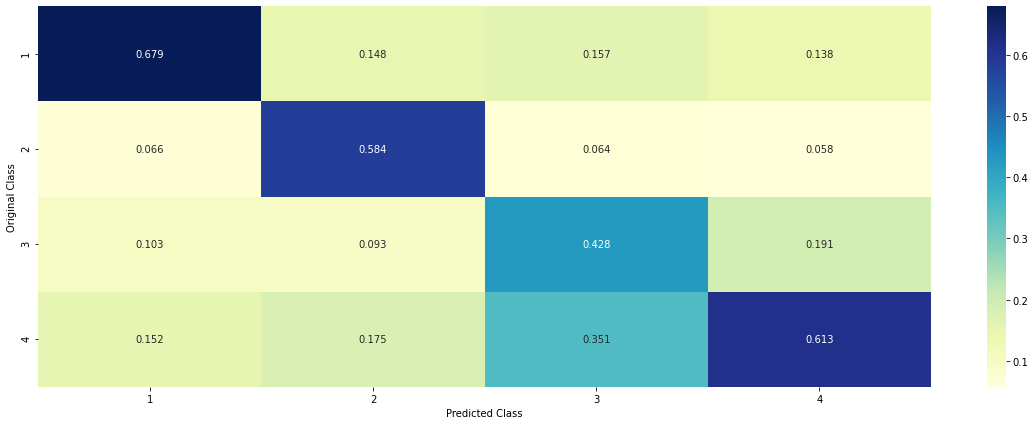

-------------------- Recall matrix (Row sum=1) --------------------


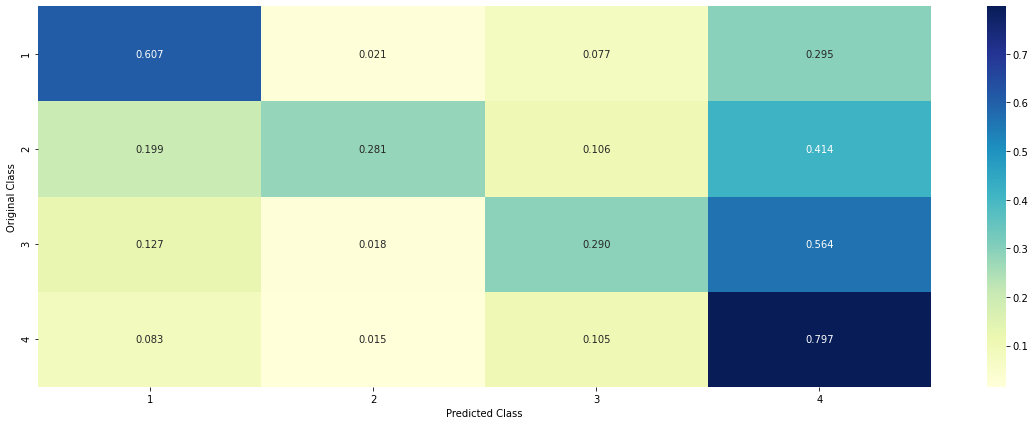

In [44]:
learning_rate=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in learning_rate:
    model = None
    model = xgb.XGBClassifier(learning_rate=i,class_weight='balanced')
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at learning_rate={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(learning_rate,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each learning_rate")
plt.xlabel("hyper parameter (learning_rate)")
plt.ylabel("F1 score")
plt.show()

best_n = learning_rate[np.argmax(f1_scores)]


model = None
model = xgb.XGBClassifier(learning_rate=best_n,class_weight='balanced')
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

<b> XGBoost with fine hyperparameter tuning

In [45]:
param_grid = {
    'max_depth': [2,3,4,5,6,7,8],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [5,10,50,100,200,250]}

clf = xgb.XGBClassifier(n_jobs=-1 ,early_stopping_rounds = 10, eta = 0.02,class_weight='balanced')
random_search = RandomizedSearchCV(clf, param_grid, n_iter=30,n_jobs=-1,scoring="f1_macro", verbose=1, cv=5, refit=False, random_state=42)
random_search.fit(train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           class_weight='balanced',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=10, eta=0.02,
                                           gamma=None, gpu_id=None,
                                           importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=No...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha

In [46]:
params = random_search.best_params_

In [47]:
params

{'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.3}

[11:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train F1 score is  :0.8802419943531 
**************************************************
test F1 score is :0.5272284377857827 
-------------------- Confusion matrix --------------------


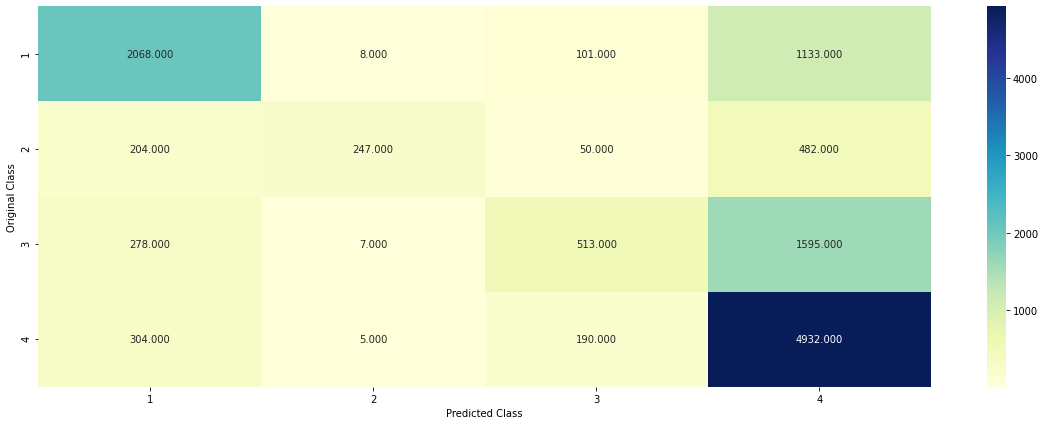

-------------------- Precision matrix (Columm Sum=1) --------------------


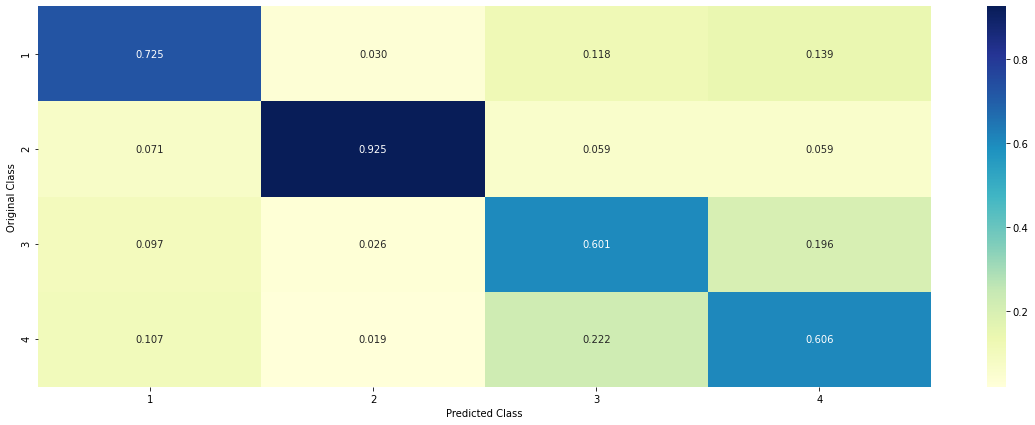

-------------------- Recall matrix (Row sum=1) --------------------


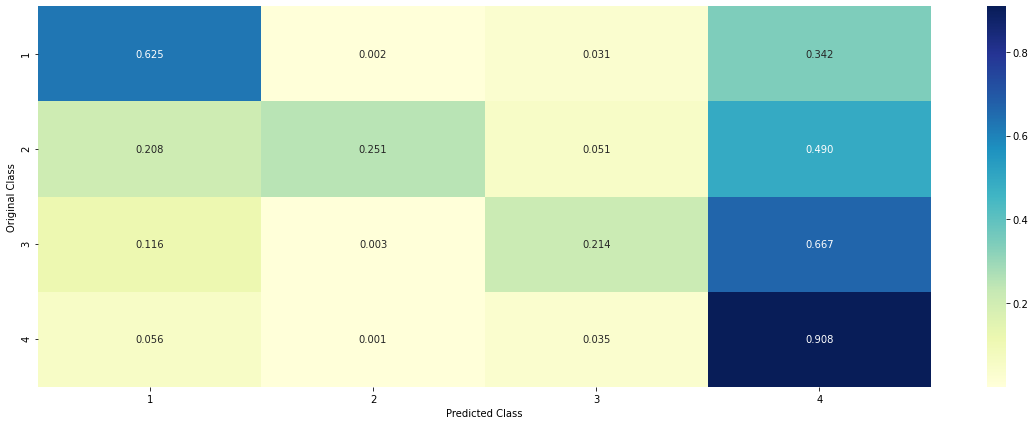

In [48]:
clf = xgb.XGBClassifier(n_estimators= params["n_estimators"], max_depth= params["max_depth"],
                        learning_rate= params["learning_rate"]  ,early_stopping_rounds = 10,eta = 0.02,class_weight='balanced')

clf.fit(train,y_train)

pred_test = clf.predict(test)
pred_train = clf.predict(train)

print("Train F1 score is  :{} ".format(f1_score(y_train,pred_train,labels=[1,2,3,4],average="macro")))
print("*"*50)
print("test F1 score is :{} ".format(f1_score(y_test,pred_test,labels=[1,2,3,4],average="macro")))

plot_confusion_matrix(y_test,pred_test)

### 1.4 Random Over Sampling

In [49]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [50]:
om = RandomOverSampler(random_state=10) 
x_res , y_res = om.fit_resample(train_features,y_train)

In [51]:
x_res.shape

(65176, 60)

In [52]:
print("class distribution BEFORE SMOTE in train data: \n",y_train.value_counts())
print("class distribution AFTER SMOTE in train data: \n",y_res.value_counts())

class distribution BEFORE SMOTE in train data: 
 4    16294
1     9931
3     7180
2     2946
Name: review_score, dtype: int64
class distribution AFTER SMOTE in train data: 
 1    16294
3    16294
4    16294
2    16294
Name: review_score, dtype: int64


In [53]:
def kfold_sampling(k,model):
    """This function will do stratified k-fold cross_validation"""
    kf = StratifiedKFold(n_splits=k)
    
    cv_f1_score = []
    for tr_ind,cv_ind in kf.split(x_res,y_res):
            
        x_tr,x_cv,y_tr,y_cv = x_res[tr_ind],x_res[cv_ind],y_res[tr_ind],y_res[cv_ind]
        
        model.fit(x_tr,y_tr)
        pred_cv = model.predict(x_cv)    
        cv_f1_score.append((f1_score(y_cv,pred_cv,average="macro",labels=[1,2,3,4])))
    
    return np.mean(cv_f1_score)   
            

### 1.4.1 Logistic Regression:

Macro F1 score at C=1e-05 is 0.302074131236081 
Macro F1 score at C=0.0001 is 0.3290341658275457 
Macro F1 score at C=0.001 is 0.34402585966578497 
Macro F1 score at C=0.01 is 0.3498104380134787 
Macro F1 score at C=0.1 is 0.3521571193367433 
Macro F1 score at C=1 is 0.35217567538409694 
Macro F1 score at C=10 is 0.352461370786819 
**************************************************


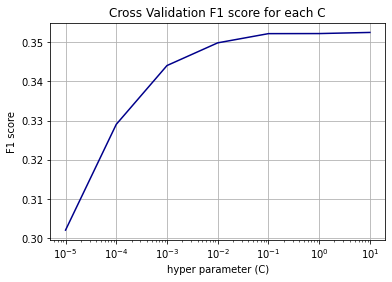

**************************************************
Train F1 score at 10 is :0.3541984230508761
**************************************************
test F1 score at 10 is :0.3603476117597647
-------------------- Confusion matrix --------------------


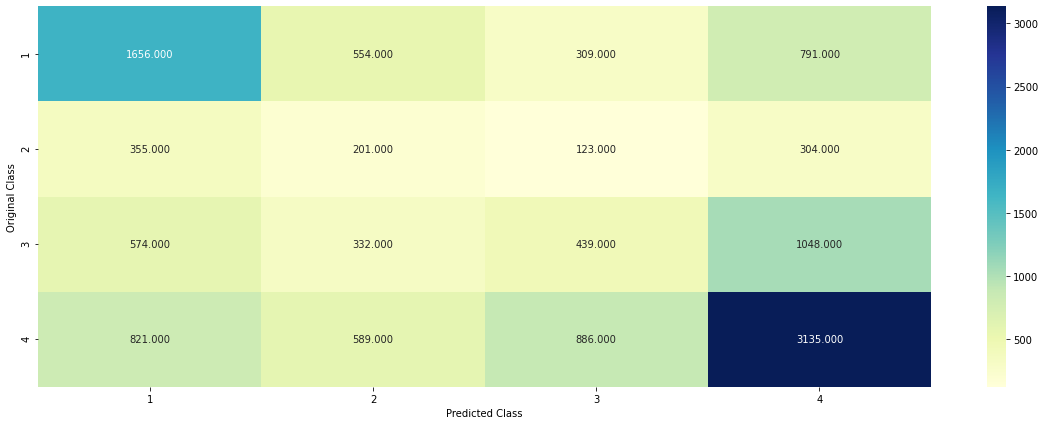

-------------------- Precision matrix (Columm Sum=1) --------------------


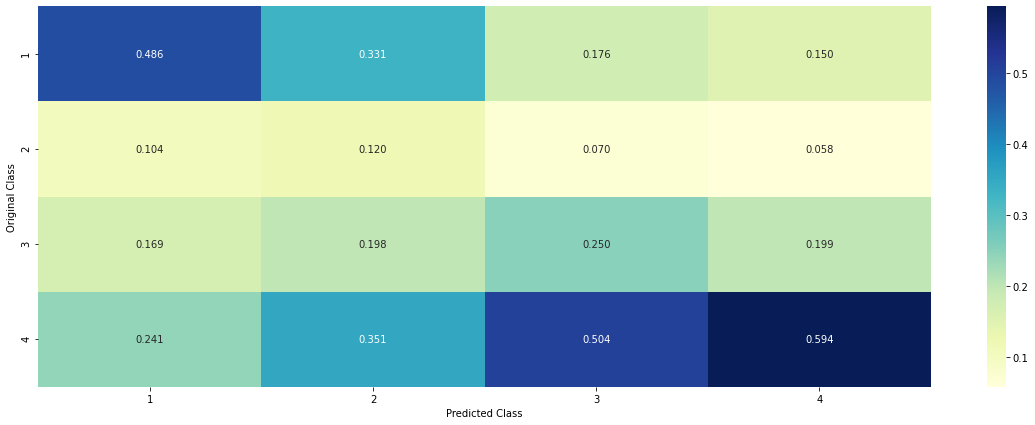

-------------------- Recall matrix (Row sum=1) --------------------


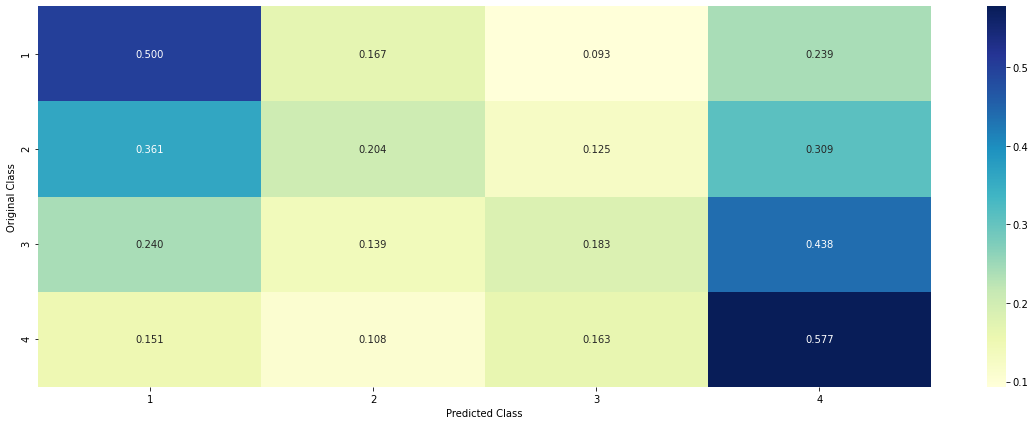

In [54]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### 1.4.2. Decision Tree

Macro F1 score at n=2 is 0.24382369991778777 
Macro F1 score at n=5 is 0.3389760034415418 
Macro F1 score at n=6 is 0.35346378660162986 
Macro F1 score at n=8 is 0.3762400697250904 
Macro F1 score at n=10 is 0.42435985068977916 
Macro F1 score at n=12 is 0.46914171296168466 
Macro F1 score at n=15 is 0.5460621833268051 
Macro F1 score at n=20 is 0.6669306969768977 
**************************************************


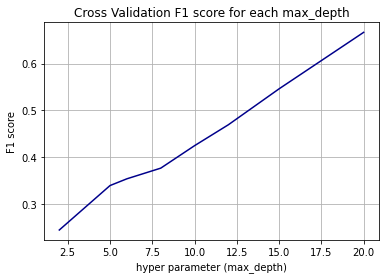

**************************************************
Train F1 score at 20 is :0.7634176613138941
**************************************************
test F1 score at 20 is :0.4615182888479491
-------------------- Confusion matrix --------------------


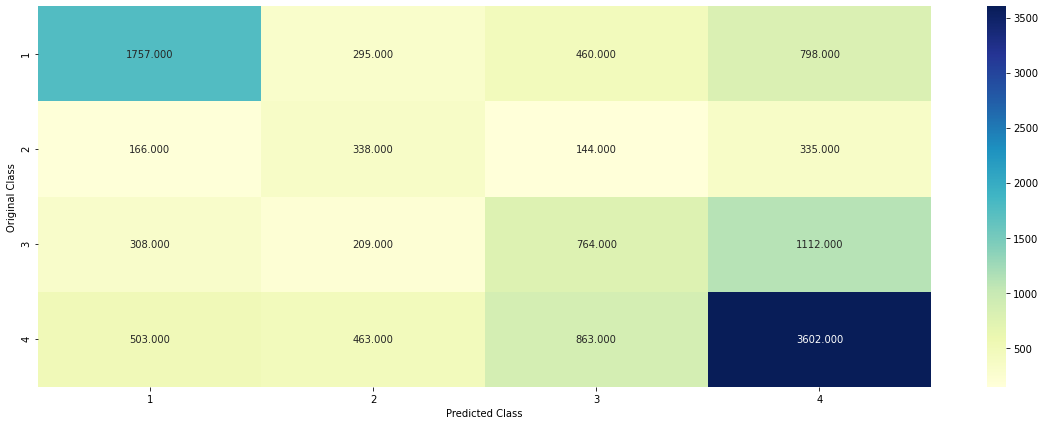

-------------------- Precision matrix (Columm Sum=1) --------------------


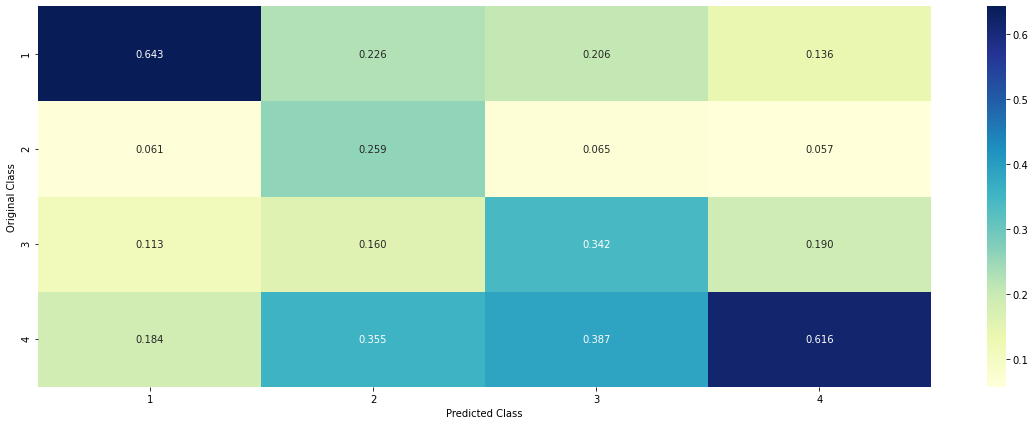

-------------------- Recall matrix (Row sum=1) --------------------


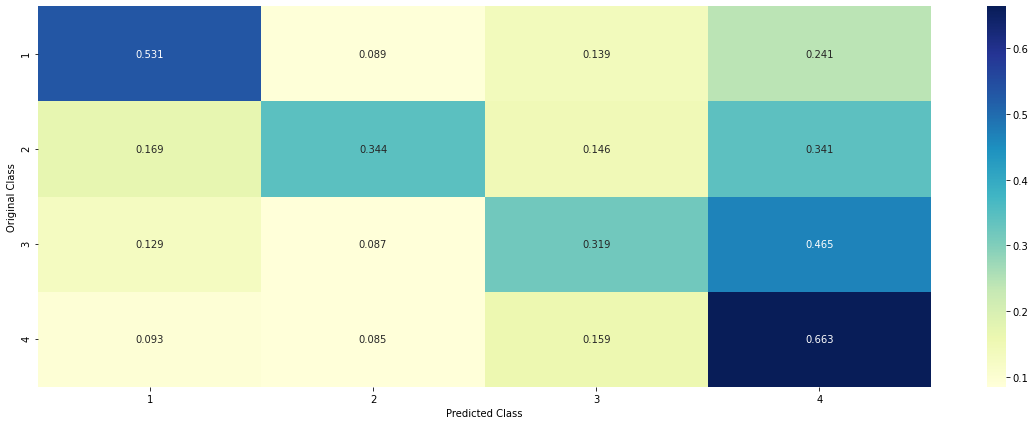

In [55]:
max_depth=[2,5,6,8,10,12,15,20]

f1_scores = []
for i in max_depth:
    model = None
    model = DecisionTreeClassifier(max_depth=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(max_depth,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each max_depth")
plt.xlabel("hyper parameter (max_depth)")
plt.ylabel("F1 score")
plt.show()

best_param = max_depth[np.argmax(f1_scores)]

model = None
model = DecisionTreeClassifier(max_depth=best_param)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### RF

Macro F1 score at n=10 is 0.8506991868226434 
Macro F1 score at n=20 is 0.8806786852704456 
Macro F1 score at n=50 is 0.904239376312829 
Macro F1 score at n=100 is 0.9121565104552504 
Macro F1 score at n=150 is 0.9160924963700889 
Macro F1 score at n=200 is 0.918129771421191 
Macro F1 score at n=300 is 0.9186937492421705 
Macro F1 score at n=500 is 0.920323616321195 
**************************************************


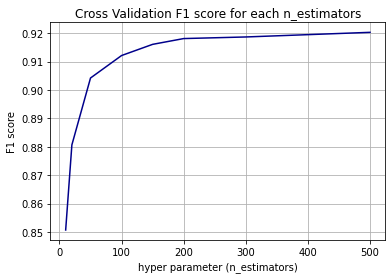

**************************************************
Train F1 score at 500 is :0.9987572938141489
**************************************************
test F1 score at 500 is :0.5729616235899773
-------------------- Confusion matrix --------------------


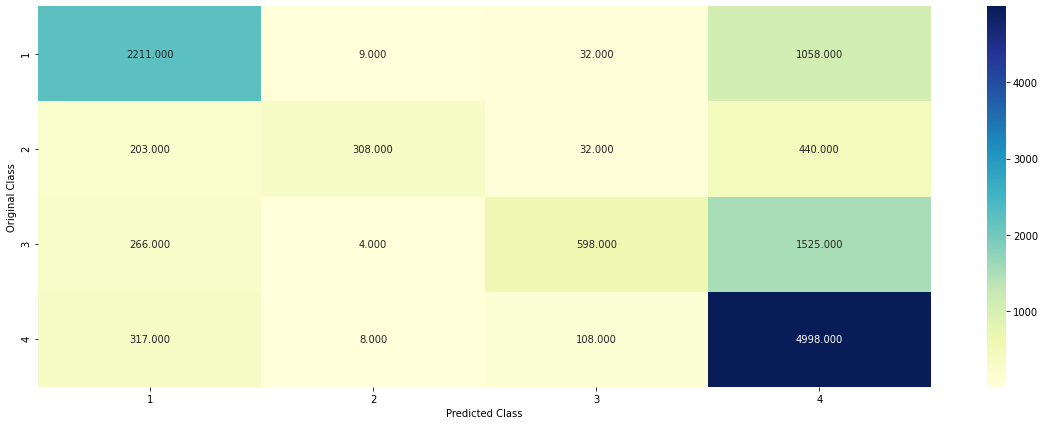

-------------------- Precision matrix (Columm Sum=1) --------------------


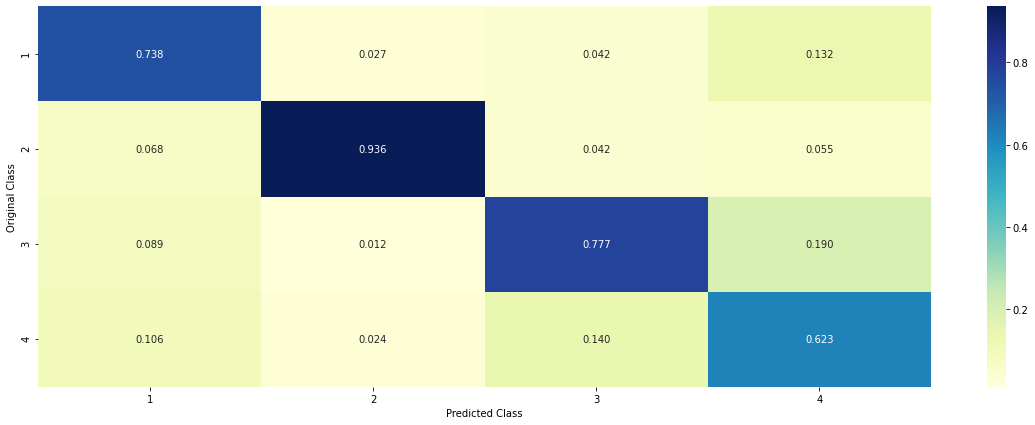

-------------------- Recall matrix (Row sum=1) --------------------


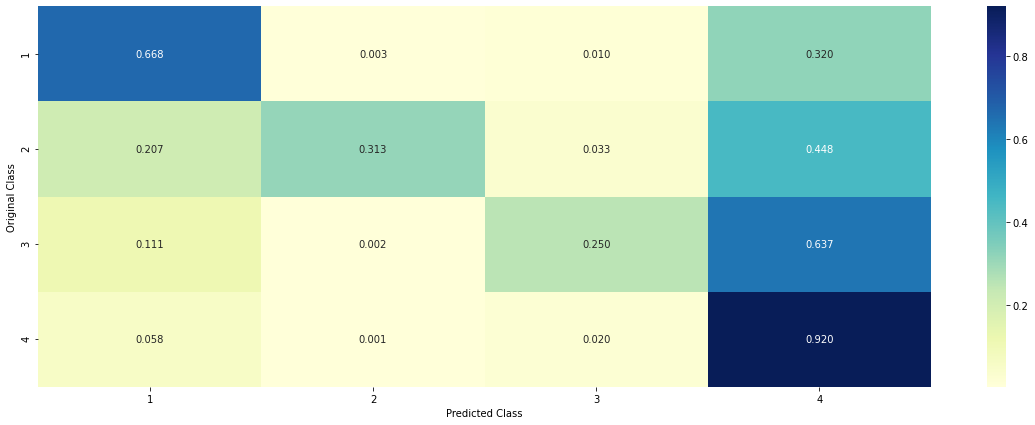

In [56]:
n_estimators=[10,20,50,100,150,200,300,500]


f1_scores = []
for i in n_estimators:
    model = None
    model = RandomForestClassifier(n_estimators=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_param = n_estimators[np.argmax(f1_scores)]

model = None
model = RandomForestClassifier(n_estimators=best_param)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### XGBRF model

[12:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[12:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

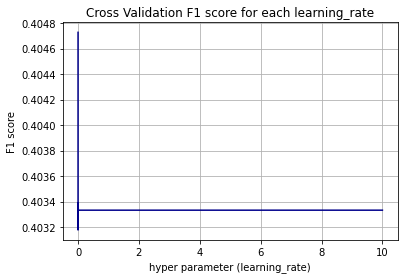

[12:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************
Train F1 score at 1e-05 is  :0.42279092545950353 
**************************************************
test F1 score at 1e-05 is :0.3813711938290445 
-------------------- Confusion matrix --------------------


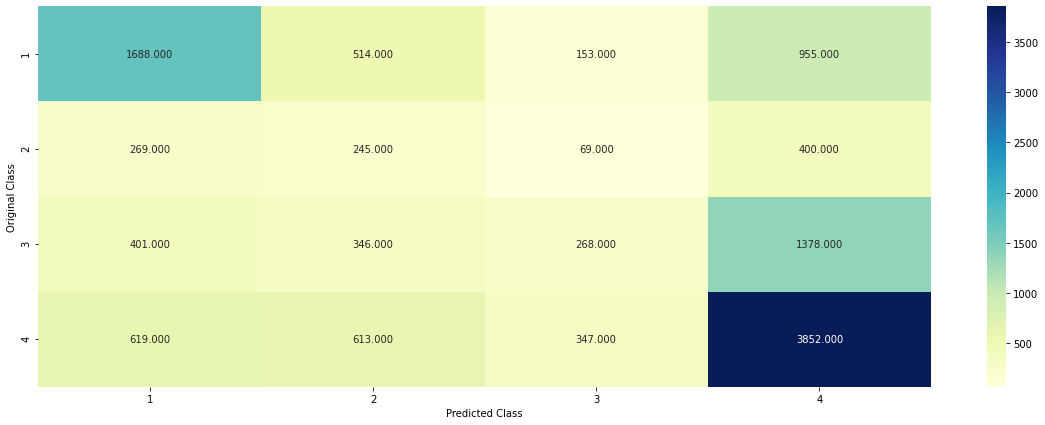

-------------------- Precision matrix (Columm Sum=1) --------------------


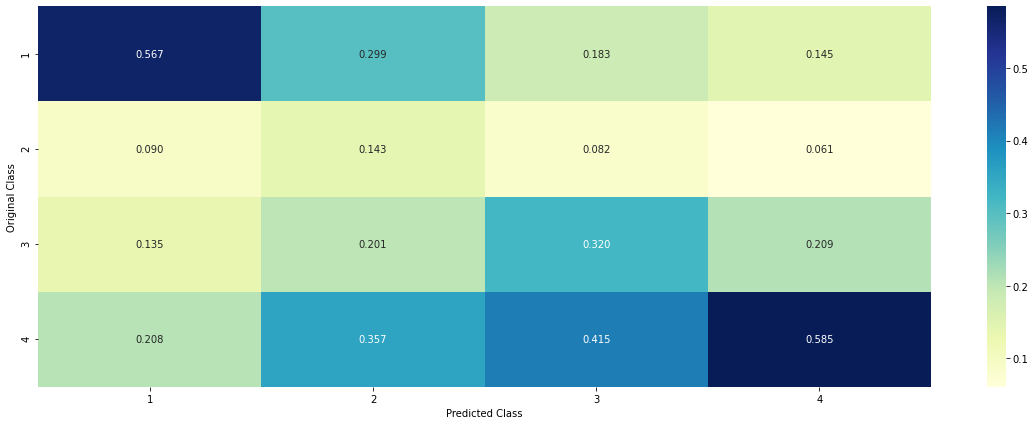

-------------------- Recall matrix (Row sum=1) --------------------


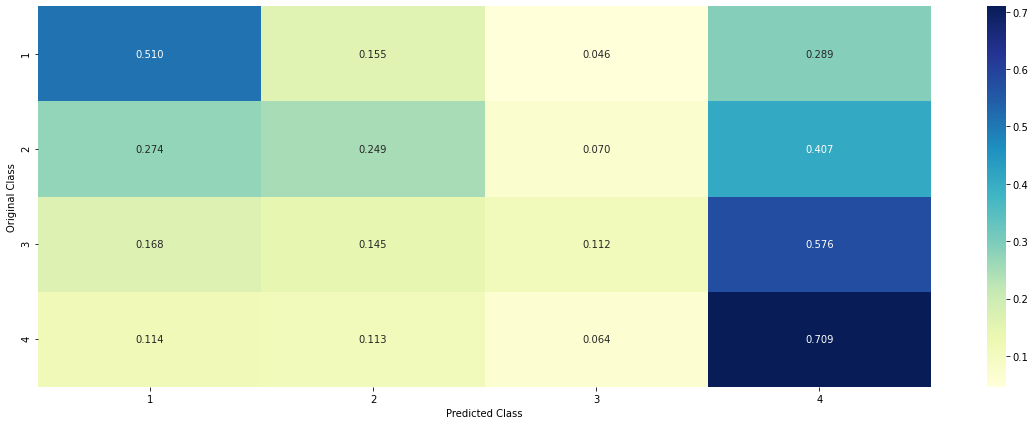

In [57]:
learning_rate=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in learning_rate:
    model = None
    model = xgb.XGBRFClassifier(learning_rate=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at learning_rate={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(learning_rate,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each learning_rate")
plt.xlabel("hyper parameter (learning_rate)")
plt.ylabel("F1 score")
plt.show()

best_n = learning_rate[np.argmax(f1_scores)]


model = None
model = xgb.XGBRFClassifier(learning_rate=best_n)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### 1.4.3. LGBM

In [58]:
param_grid = { 
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [5,10,50,100,200,250]}

clf = lgb.LGBMClassifier(n_jobs=-1,boosting_type="goss")
random_search = RandomizedSearchCV(clf, param_grid, n_iter=30,n_jobs=-1,scoring="f1_macro",
                                   verbose=1, cv=5, refit=False, random_state=42)
random_search.fit(x_res, y_res)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(boosting_type='goss'),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'n_estimators': [5, 10, 50, 100, 200,
                                                         250]},
                   random_state=42, refit=False, scoring='f1_macro', verbose=1)

In [59]:
params = random_search.best_params_

In [60]:
print(params)

{'n_estimators': 250, 'learning_rate': 0.2}


Train F1 score is  :0.9052961200414245 
**************************************************
test F1 score is :0.48418381391979004 
-------------------- Confusion matrix --------------------


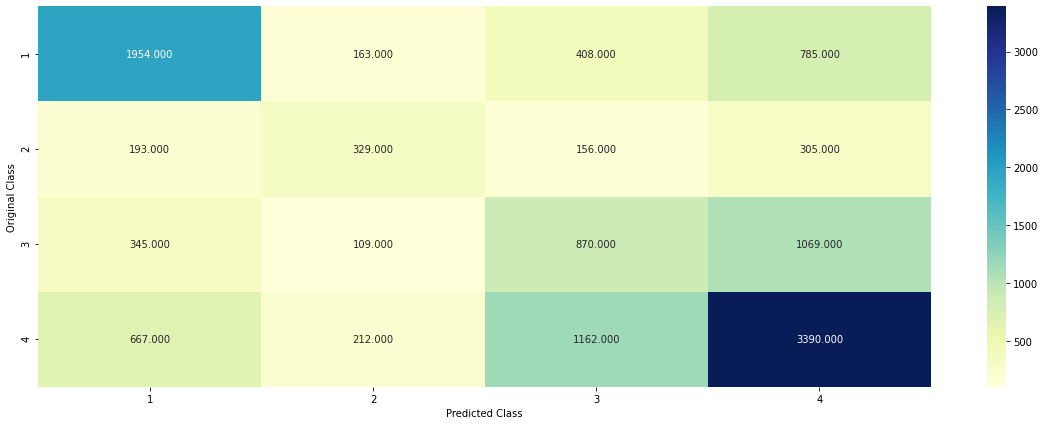

-------------------- Precision matrix (Columm Sum=1) --------------------


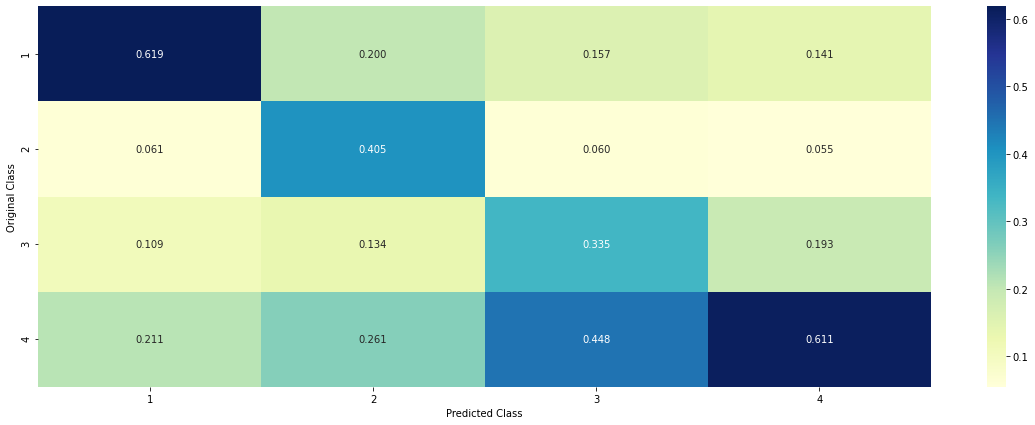

-------------------- Recall matrix (Row sum=1) --------------------


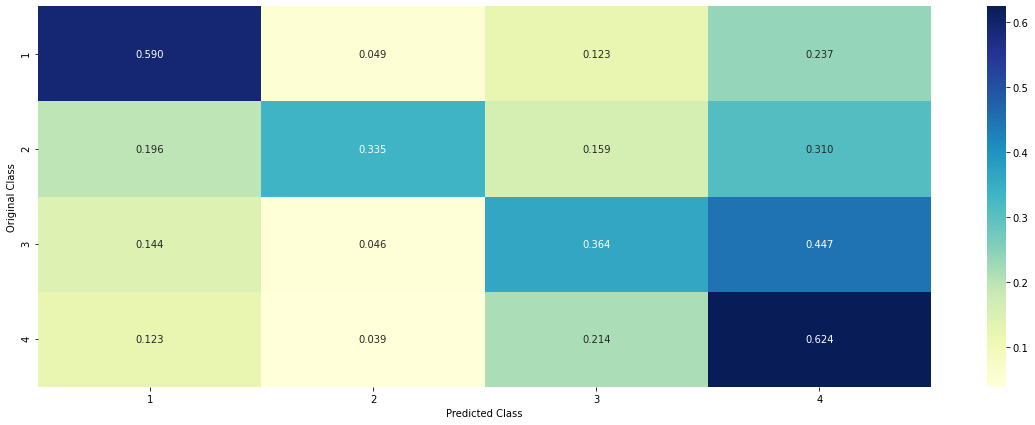

In [61]:
clf = lgb.LGBMClassifier(n_estimators= params["n_estimators"],
                         boosting_type="goss",
                        learning_rate= params["learning_rate"], n_jobs=-1)
clf.fit(x_res,y_res)

pred_test = clf.predict(test_features)
pred_train = clf.predict(x_res)

print("Train F1 score is  :{} ".format(f1_score(y_res,pred_train,labels=[1,2,3,4],average="macro")))
print("*"*50)
print("test F1 score is :{} ".format(f1_score(y_test,pred_test,labels=[1,2,3,4],average="macro")))

plot_confusion_matrix(y_test,pred_test)

### SUMMARY TABLE

|Model|Train Macro F1 score|Test Macro F1 score|
|----|----|----|
|Logistic Regression|0.368 |0.358 |
|KNN| 0.691|0.409 |
|Decision Tree|0.515 |0.416 |
|Random Forest|0.997 |0.553 |
|LGBM|0.997 |0.545 |
|XGBoost|0.948 |0.515 |
|XGBoost(fine tune)|0.88 |0.527 |

<b> Feature selection</b>

|Model|Train Macro F1 score|Test Macro F1 score|
|----|----|----|
|LGBM|0.997 |0.537 |

<b> Random Oversampling</b>

|Model|Train Macro F1 score|Test Macro F1 score|
|----|----|----|
|Logistic Regression|0.354 |0.360 |
|Decision Tree|0.76 |0.46 |
|Random Forest|0.998 |0.573 |
|LGBM|0.905 |0.484 |
|XGBRF|0.42 |0.38 |
